In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint



2023-10-31 22:14:05.577212: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 22:14:05.637981: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 22:14:05.972400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 22:14:05.972592: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 22:14:05.974353: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

# Load Data

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("The MNIST dataset has a training set of %d examples." % len(X_train))
print("The MNIST database has a test set of %d examples." % len(X_test))

The MNIST dataset has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


# Visualization

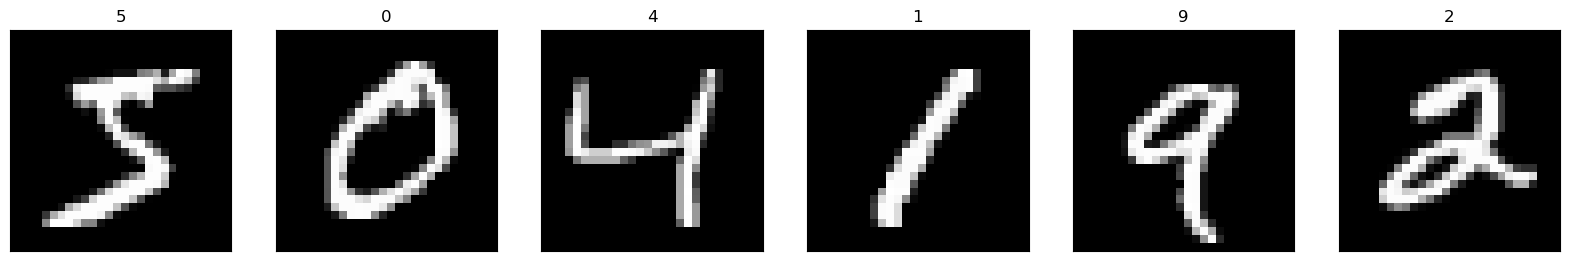

In [5]:
# plot of first six training images

fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

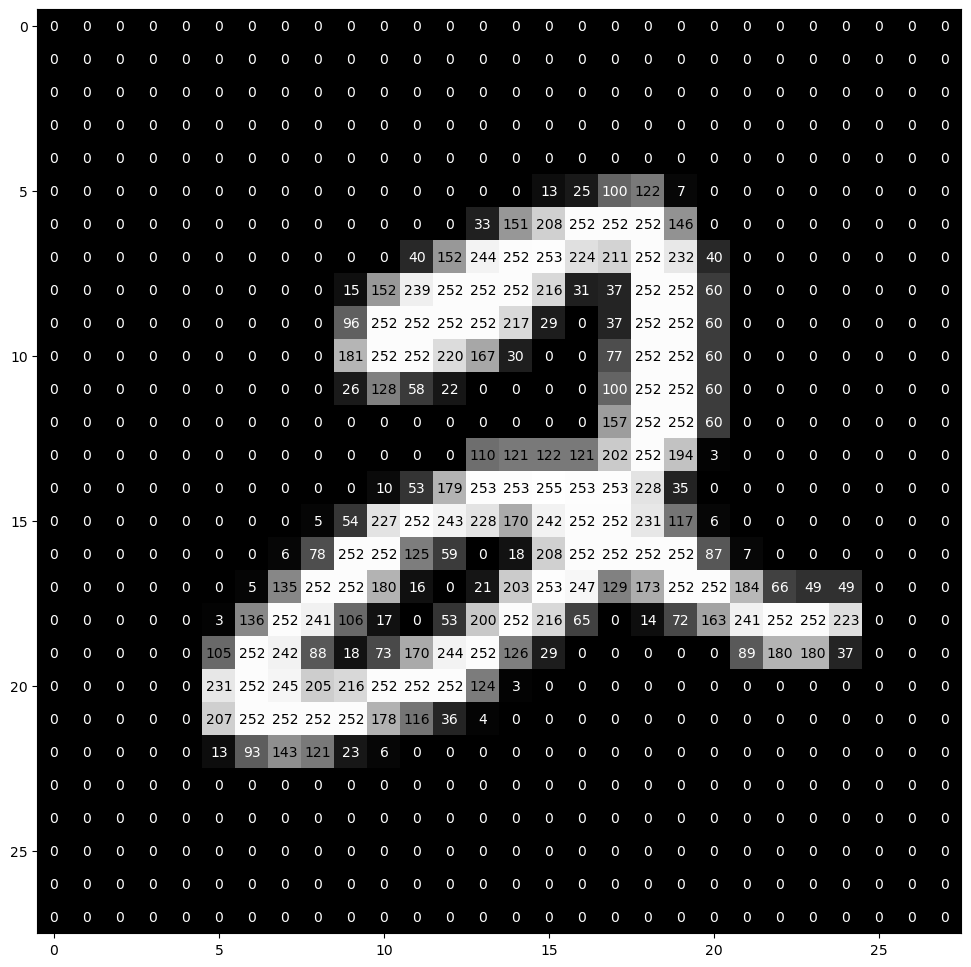

In [6]:
# plot of an image in more detail

def visualize_img (img,ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
visualize_img(X_train[5], ax)

# Preprocessing

In [7]:
# rescale to have values within 0 - 1 range ((0,1) => (0,255))
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

print('X_train shape:', X_train.shape)
print("Height, Width of each image in pixels : ",X_train.shape[1:3])
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Height, Width of each image in pixels :  (28, 28)
60000 train samples
10000 test samples


In [8]:
# one-hot encoding using keras utilities

num_classes = 10
# print first ten (integer-valued) training labels
print('Integer-valued labels:')
print(y_train[:10])

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [9]:
# reshape data to fit our cnn 

img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) 
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('input_shape: ', input_shape)
print('x_train shape:', X_train.shape)

input_shape:  (28, 28, 1)
x_train shape: (60000, 28, 28, 1)


# Building model and training

In [10]:
# build the model object
model = Sequential()

# CONV_1: add CONV layer with RELU activation and depth = 32 filters each having size 3x3 and the input is padded with zeros such that input shape is same as that of the feature map
model.add(Conv2D(32, kernel_size=(3, 3), padding='same',activation='relu',input_shape=(28,28,1)))
# POOL_1: downsample the image to choose the best features
model.add(MaxPooling2D(pool_size=(2, 2)))

# CONV_2: here we increase the depth to 64
model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
# POOL_2: more downsampling
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten since too many dimensions, we only want a classification output
model.add(Flatten())

# FC_1: fully connected to get all relevant data
model.add(Dense(64, activation='relu'))

# FC_2: output a softmax to squash the matrix into output probabilities for the 10 classes
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                2

every output shape has None in place of the batch-size. This is so as to facilitate changing of batch size at runtime.

In [11]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

In [12]:
# train the model
checkpointer = ModelCheckpoint(filepath='model_weights_best.hdf5', verbose=1,
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=64, epochs=10,
          validation_data=(X_test, y_test), callbacks=[checkpointer],
          verbose=2, shuffle=True)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.04465, saving model to model_weights_best.hdf5
938/938 - 49s - loss: 0.1713 - accuracy: 0.9467 - val_loss: 0.0447 - val_accuracy: 0.9867 - 49s/epoch - 53ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.04465 to 0.03224, saving model to model_weights_best.hdf5
938/938 - 48s - loss: 0.0475 - accuracy: 0.9853 - val_loss: 0.0322 - val_accuracy: 0.9883 - 48s/epoch - 51ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.03224 to 0.03129, saving model to model_weights_best.hdf5
938/938 - 49s - loss: 0.0325 - accuracy: 0.9902 - val_loss: 0.0313 - val_accuracy: 0.9895 - 49s/epoch - 52ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.03129 to 0.02678, saving model to model_weights_best.hdf5
938/938 - 49s - loss: 0.0244 - accuracy: 0.9924 - val_loss: 0.0268 - val_accuracy: 0.9904 - 49s/epoch - 52ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.02678
938/938 - 47s - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0318 - val_

In [13]:
# load the weights that yielded the best validation accuracy
model.load_weights('model_weights_best.hdf5')

Test accuracy: 99.0400%


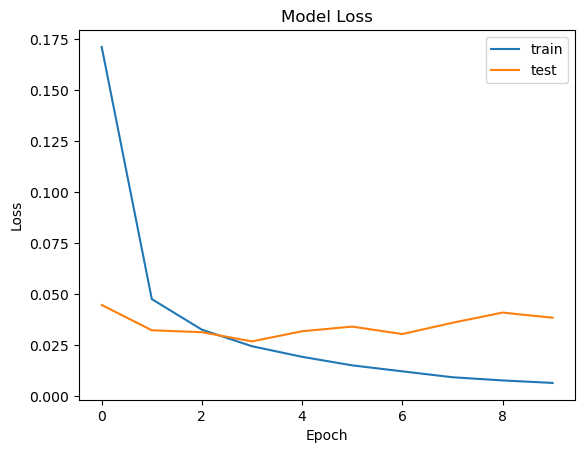

In [15]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])

In [16]:
# save the model

model.save('model.h5')